In [67]:
import numpy as np
import pandas as pd

import pymc3 as pm
import theano.tensor as tt

from datetime import datetime, timedelta

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.left'] = False

PRIOR_N = 50
ELECTION_DATE = '2021-01-05'

In [68]:
def exp_decay(data_date, election_date):
    '''Weights polls with exponential decay setting 14 days before election at 0.5 weight'''
    # calculate time delta 
    td = (election_date - data_date).days
    
    # calculate the exponential decay
    return 0.5 ** (td / 30.)

In [69]:
# https://projects.fivethirtyeight.com/2020-ga-runoff-data/ga_runoff_polls_2020.csv
ga_runoff = pd.read_csv('data/ga_runoff_full.csv')
ga_runoff['startdate'] = pd.to_datetime(ga_runoff['startdate'])
ga_runoff['enddate'] = pd.to_datetime(ga_runoff['enddate'])
ga_runoff.head()

,candidate_name,startdate,enddate,pollster,samplesize,pct
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,1064,50.0
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,1064,48.0
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,1064,52.0
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,1064,46.0
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,605,51.0


In [70]:
candidates = ga_runoff['candidate_name'].unique().tolist()
candidates

['David A. Perdue', 'Jon Ossoff', 'Kelly Loeffler', 'Raphael Warnock']

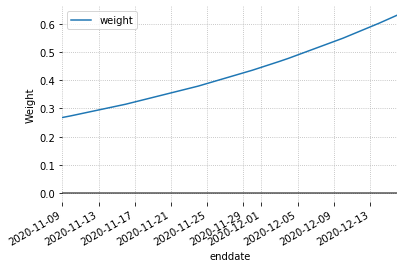

In [71]:
# weight the poll by end date
ga_runoff['weight'] = ga_runoff['enddate'].apply(exp_decay, args=(datetime.strptime(ELECTION_DATE, '%Y-%m-%d'),))
#ga_runoff['weight'] = 1
ga_runoff.plot(x='enddate', y='weight')
plt.grid(linestyle=':')
plt.ylabel('Weight')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
#plt.legend(set_visible=False)
plt.savefig('imgs/exponential_decay.png')

In [72]:
# apply weight to sample size
ga_runoff['samplesize'] = ga_runoff['samplesize'] * ga_runoff['weight']
ga_runoff.head()

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,670.277999,50.0,0.629961
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,670.277999,48.0,0.629961
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,670.277999,52.0,0.629961
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,670.277999,46.0,0.629961
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,381.126118,51.0,0.629961


# Warnock v Loeffler

In [73]:
# Nov 3, 2020 results used as prior (total party support used as prior)
w_pct = 0.329 + 0.066 + 0.028 + 0.022 + 0.019 + 0.009 + 0.006
l_pct = 0.259 + 0.20 + 0.01 + 0.009 + 0.008 + 0.007

# normalize the split because the race is only between the two now
w_pct_norm = w_pct / (w_pct + l_pct)
l_pct_norm = l_pct / (w_pct + l_pct)

w_pct_norm, l_pct_norm

(0.492798353909465, 0.507201646090535)

In [74]:
warnock_polls = ga_runoff[ga_runoff.candidate_name == 'Raphael Warnock']
# only use most recent poll from pollsters that do multiple
warnock_polls = warnock_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
warnock_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight
29,Raphael Warnock,2020-11-08,2020-11-09,Remington Research Group,388.517880,48.0,0.267943
27,Raphael Warnock,2020-11-10,2020-11-10,VCreek/AMG,82.261873,45.6,0.274206
28,Raphael Warnock,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,49.0,0.314980
25,Raphael Warnock,2020-11-19,2020-11-24,RMG Research,521.785428,48.0,0.378929
26,Raphael Warnock,2020-11-27,2020-11-30,SurveyUSA,253.765489,52.0,0.435275
23,Raphael Warnock,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,47.0,0.477421
11,Raphael Warnock,2020-12-10,2020-12-14,Wick,902.268777,48.0,0.601513
15,Raphael Warnock,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,48.0,0.601513
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,670.277999,46.0,0.629961
7,Raphael Warnock,2020-12-14,2020-12-16,Emerson College,381.126118,49.0,0.629961


In [75]:
loeffler_polls = ga_runoff[ga_runoff.candidate_name == 'Kelly Loeffler']
# only use most recent poll from pollsters that do multiple
loeffler_polls = loeffler_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
loeffler_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight
35,Kelly Loeffler,2020-11-08,2020-11-09,Remington Research Group,388.517880,49.0,0.267943
33,Kelly Loeffler,2020-11-10,2020-11-10,VCreek/AMG,82.261873,49.5,0.274206
34,Kelly Loeffler,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,48.0,0.314980
31,Kelly Loeffler,2020-11-19,2020-11-24,RMG Research,521.785428,46.0,0.378929
32,Kelly Loeffler,2020-11-27,2020-11-30,SurveyUSA,253.765489,45.0,0.435275
22,Kelly Loeffler,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,46.0,0.477421
10,Kelly Loeffler,2020-12-10,2020-12-14,Wick,902.268777,50.0,0.601513
14,Kelly Loeffler,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,49.0,0.601513
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,670.277999,52.0,0.629961
6,Kelly Loeffler,2020-12-14,2020-12-16,Emerson College,381.126118,51.0,0.629961


In [76]:
poll_normalizer = warnock_polls[['pollster', 'pct', 'enddate']].merge(loeffler_polls[['pollster', 'pct', 'enddate']], on=['pollster', 'enddate'])
poll_normalizer['normalizer'] = poll_normalizer['pct_x'] + poll_normalizer['pct_y']
poll_normalizer['pct_x'] /= poll_normalizer['normalizer']
poll_normalizer['pct_y'] /= poll_normalizer['normalizer']
poll_normalizer

,pollster,pct_x,enddate,pct_y,normalizer
0,Remington Research Group,0.494845,2020-11-09,0.505155,97.0
1,VCreek/AMG,0.479495,2020-11-10,0.520505,95.1
2,Opinion Savvy/InsiderAdvantage,0.505155,2020-11-16,0.494845,97.0
3,RMG Research,0.510638,2020-11-24,0.489362,94.0
4,SurveyUSA,0.536082,2020-11-30,0.463918,97.0
5,Fabrizio Ward/ Hart Research Associates,0.505376,2020-12-04,0.494624,93.0
6,Wick,0.489796,2020-12-14,0.510204,98.0
7,InsiderAdvantage,0.494845,2020-12-14,0.505155,97.0
8,Trafalgar Group,0.469388,2020-12-16,0.530612,98.0
9,Emerson College,0.490000,2020-12-16,0.510000,100.0


In [77]:
# add in the normalized values to warnock polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _pollster, _pct = norm_row['enddate'], norm_row['pollster'], norm_row['pct_x']
    warnock_polls.loc[(warnock_polls.enddate == _date) & (warnock_polls.pollster == _pollster), 'pct'] = _pct
    
warnock_polls['num_votes'] = warnock_polls['samplesize'] * warnock_polls['pct']
warnock_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,num_votes
29,Raphael Warnock,2020-11-08,2020-11-09,Remington Research Group,388.517880,0.494845,0.267943,192.256271
27,Raphael Warnock,2020-11-10,2020-11-10,VCreek/AMG,82.261873,0.479495,0.274206,39.444179
28,Raphael Warnock,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,0.505155,0.314980,127.290993
25,Raphael Warnock,2020-11-19,2020-11-24,RMG Research,521.785428,0.510638,0.378929,266.443623
26,Raphael Warnock,2020-11-27,2020-11-30,SurveyUSA,253.765489,0.536082,0.435275,136.039231
23,Raphael Warnock,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,0.505376,0.477421,301.596474
11,Raphael Warnock,2020-12-10,2020-12-14,Wick,902.268777,0.489796,0.601513,441.927564
15,Raphael Warnock,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,0.494845,0.601513,148.827840
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,670.277999,0.469388,0.629961,314.620285
7,Raphael Warnock,2020-12-14,2020-12-16,Emerson College,381.126118,0.490000,0.629961,186.751798


In [78]:
# group by pollster
warnock_pollsters = (
    warnock_polls[['pollster', 'samplesize', 'num_votes']]
    .groupby('pollster')
    .agg(np.sum)
)
warnock_pollsters

,samplesize,num_votes
pollster,,
Emerson College,381.126118,186.751798
Fabrizio Ward/ Hart Research Associates,596.776002,301.596474
InsiderAdvantage,300.756259,148.827840
Opinion Savvy/InsiderAdvantage,251.984210,127.290993
RMG Research,521.785428,266.443623
Remington Research Group,388.517880,192.256271
SurveyUSA,253.765489,136.039231
Trafalgar Group,670.277999,314.620285
VCreek/AMG,82.261873,39.444179


In [79]:
# tune n for how much we want the model to 
alpha = int(w_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(24, 26)

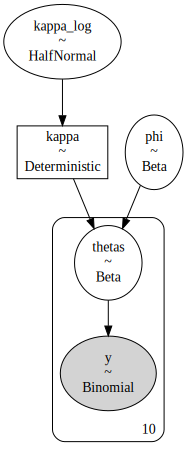

In [80]:
with pm.Model() as warnock_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=1)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(warnock_pollsters)
    )
    
    y = pm.Binomial(
        'y', 
        n=warnock_pollsters['samplesize'], 
        p=thetas, 
        observed=warnock_pollsters['num_votes']
    )
    
pm.model_to_graphviz(warnock_model)

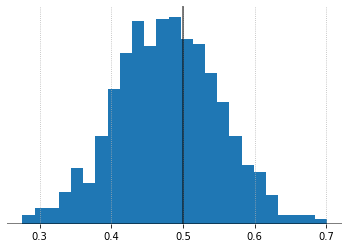

In [81]:
with warnock_model:
    warnock_prior = pm.sample_prior_predictive(samples=1000)
    
plt.hist(warnock_prior['phi'], bins=25)
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks([])
plt.show()

In [82]:
with warnock_model:
    #step = pm.Metropolis()
    warnock_samples = pm.sample(2000, tune=5000, cores=4, target_accept=0.999) # target_accept=0.99
    #post_pred = pm.sample_posterior_predictive(samples, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 47 seconds.


/home/flo/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


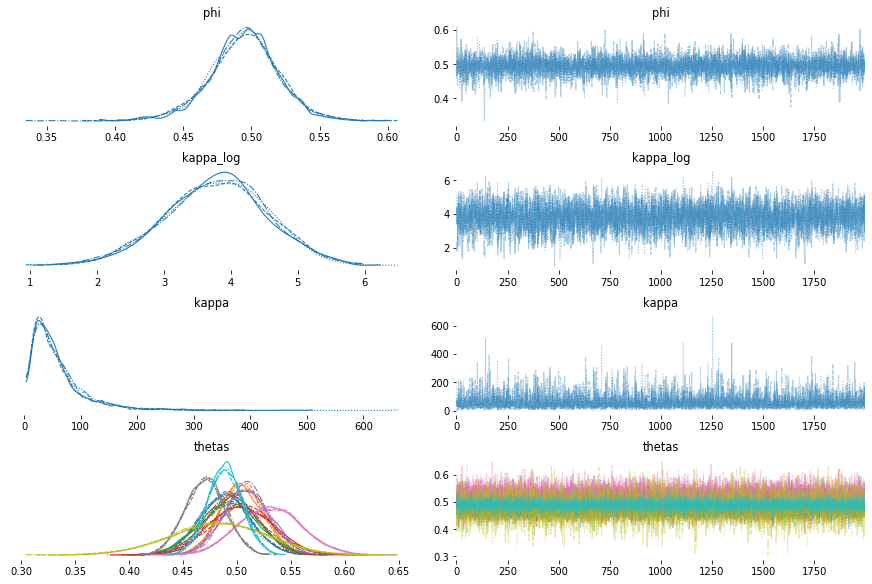

In [83]:
pm.traceplot(warnock_samples)
plt.show()

In [84]:
pm.summary(warnock_samples, hdi_prob=0.8)

/home/flo/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
phi,0.495,0.026,0.462,0.525,0.000,0.000,5728.0,5728.0,6034.0,4351.0,1.0
kappa_log,3.783,0.761,2.823,4.771,0.011,0.008,5009.0,5009.0,5124.0,4209.0,1.0
kappa,58.103,47.856,7.159,85.233,0.585,0.414,6684.0,6684.0,5124.0,4209.0,1.0
thetas[0],0.489,0.024,0.459,0.519,0.000,0.000,8280.0,8280.0,8277.0,6040.0,1.0
thetas[1],0.504,0.020,0.479,0.530,0.000,0.000,8569.0,8569.0,8584.0,5170.0,1.0
thetas[2],0.494,0.027,0.458,0.528,0.000,0.000,8572.0,8543.0,8588.0,5724.0,1.0
thetas[3],0.504,0.029,0.466,0.539,0.000,0.000,7336.0,7336.0,7356.0,5525.0,1.0
thetas[4],0.509,0.021,0.482,0.536,0.000,0.000,7613.0,7613.0,7622.0,6223.0,1.0
thetas[5],0.495,0.024,0.464,0.525,0.000,0.000,8898.0,8898.0,8887.0,5877.0,1.0
thetas[6],0.531,0.029,0.493,0.567,0.000,0.000,7559.0,7486.0,7568.0,5463.0,1.0


In [85]:
map_estimate = pm.find_MAP(model=warnock_model)
map_estimate['phi']

array(0.49608972)

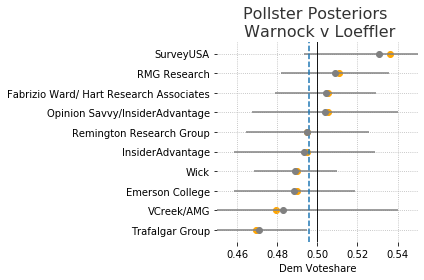

In [86]:
import scipy.stats as stats

medians = []
errs = []
labels = []
for pollster_idx in range(warnock_samples['thetas'].shape[1]):
    _median = np.mean(warnock_samples['thetas'][:,pollster_idx])
    lower, _ = np.percentile(warnock_samples['thetas'][:,pollster_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(warnock_pollsters.index.tolist()[pollster_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

#medians, errs, labels
for idx, _median in enumerate(medians):
    plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
for pollster_idx, pollster in enumerate(labels):
    plt.scatter(
        x=(
            warnock_pollsters[warnock_pollsters.index == pollster]['num_votes'] / 
            warnock_pollsters[warnock_pollsters.index == pollster]['samplesize']
        ), 
        y=pollster_idx, color='orange')
plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
plt.axvline(x=map_estimate['phi'], linestyle='--', color='tab:blue')
plt.grid(linestyle=':')
plt.yticks(np.arange(len(warnock_pollsters)), labels)
plt.xlim([0.45, 0.55])
plt.xlabel('Dem Voteshare')
plt.title('Pollster Posteriors \n Warnock v Loeffler', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/wl_pollster-lean.png', dpi=300)

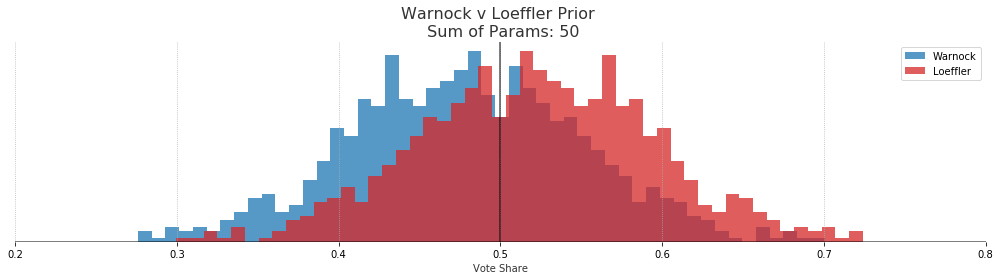

In [87]:
plt.figure(figsize=(14,4))
plt.hist(warnock_prior['phi'], color='tab:blue', alpha=0.75, bins=50, label='Warnock')
plt.hist(1. - warnock_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Loeffler')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.xlim([0.2, 0.8])
plt.legend()
plt.grid(linestyle=':')
plt.title('Warnock v Loeffler Prior \n Sum of Params: {}'.format(PRIOR_N), fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_wl_{}-priors.png'.format(PRIOR_N))

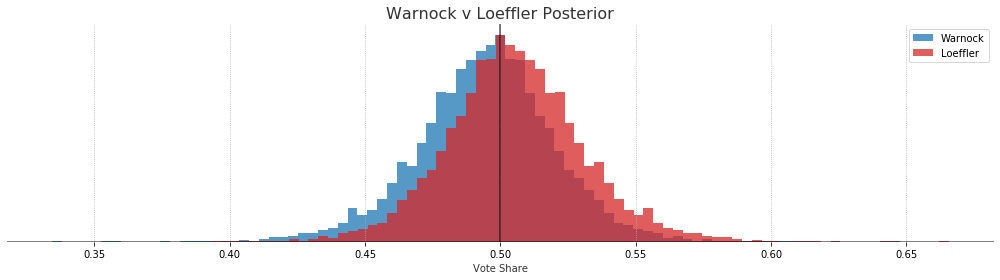

In [88]:
plt.figure(figsize=(14,4))
plt.hist(warnock_samples['phi'], color='tab:blue', alpha=0.75, bins=75, label='Warnock')
plt.hist(1. - warnock_samples['phi'], color='tab:red', alpha=0.75, bins=75, label='Loeffler')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Warnock v Loeffler Posterior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_wl_posteriors.png')

In [89]:
np.mean(warnock_samples['phi'] > 0.5), np.mean((1. - warnock_samples['phi']) > 0.5) 

(0.415125, 0.584875)

### Model Checking

In [90]:
with warnock_model:
    ppc = pm.sample_posterior_predictive(
        warnock_samples, var_names=["phi", "thetas",]
    )

In [91]:
ppc['thetas'].shape

(8000, 10)

# Ossoff v Perdue

In [92]:
# Nov 3, 2020 results used as prior
o_pct = 0.479
p_pct = 0.497

# normalize the split because the race is only between the two now
o_pct_norm = o_pct / (o_pct + p_pct)
p_pct_norm = p_pct / (o_pct + p_pct)

o_pct_norm, p_pct_norm

(0.49077868852459017, 0.5092213114754098)

In [93]:
ossoff_polls = ga_runoff[ga_runoff.candidate_name == 'Jon Ossoff']
# only use most recent poll from pollsters that do multiple
ossoff_polls = ossoff_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
ossoff_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight
40,Jon Ossoff,2020-11-08,2020-11-09,Remington Research Group,388.517880,46.0,0.267943
39,Jon Ossoff,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,49.0,0.314980
37,Jon Ossoff,2020-11-19,2020-11-24,RMG Research,521.785428,48.0,0.378929
38,Jon Ossoff,2020-11-27,2020-11-30,SurveyUSA,253.765489,50.0,0.435275
21,Jon Ossoff,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,48.0,0.477421
9,Jon Ossoff,2020-12-10,2020-12-14,Wick,902.268777,47.0,0.601513
13,Jon Ossoff,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,49.0,0.601513
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,670.277999,48.0,0.629961
5,Jon Ossoff,2020-12-14,2020-12-16,Emerson College,381.126118,49.0,0.629961


In [94]:
perdue_polls = ga_runoff[ga_runoff.candidate_name == 'David A. Perdue']
# only use most recent poll from pollsters that do multiple
perdue_polls = perdue_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
perdue_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight
45,David A. Perdue,2020-11-08,2020-11-09,Remington Research Group,388.517880,50.0,0.267943
44,David A. Perdue,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,49.0,0.314980
42,David A. Perdue,2020-11-19,2020-11-24,RMG Research,521.785428,47.0,0.378929
43,David A. Perdue,2020-11-27,2020-11-30,SurveyUSA,253.765489,48.0,0.435275
20,David A. Perdue,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,46.0,0.477421
8,David A. Perdue,2020-12-10,2020-12-14,Wick,902.268777,51.0,0.601513
12,David A. Perdue,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,48.0,0.601513
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,670.277999,50.0,0.629961
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,381.126118,51.0,0.629961


In [95]:
poll_normalizer = ossoff_polls[['pollster', 'pct', 'enddate']].merge(perdue_polls[['pollster', 'pct', 'enddate']], on=['pollster', 'enddate'])
poll_normalizer['normalizer'] = poll_normalizer['pct_x'] + poll_normalizer['pct_y']
poll_normalizer['pct_x'] /= poll_normalizer['normalizer']
poll_normalizer['pct_y'] /= poll_normalizer['normalizer']
poll_normalizer

,pollster,pct_x,enddate,pct_y,normalizer
0,Remington Research Group,0.479167,2020-11-09,0.520833,96.0
1,Opinion Savvy/InsiderAdvantage,0.500000,2020-11-16,0.500000,98.0
2,RMG Research,0.505263,2020-11-24,0.494737,95.0
3,SurveyUSA,0.510204,2020-11-30,0.489796,98.0
4,Fabrizio Ward/ Hart Research Associates,0.510638,2020-12-04,0.489362,94.0
5,Wick,0.479592,2020-12-14,0.520408,98.0
6,InsiderAdvantage,0.505155,2020-12-14,0.494845,97.0
7,Trafalgar Group,0.489796,2020-12-16,0.510204,98.0
8,Emerson College,0.490000,2020-12-16,0.510000,100.0


In [96]:
# add in the normalized values to warnock polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _pollster, _pct = norm_row['enddate'], norm_row['pollster'], norm_row['pct_x']
    ossoff_polls.loc[(ossoff_polls.enddate == _date) & (ossoff_polls.pollster == _pollster), 'pct'] = _pct
    
ossoff_polls['num_votes'] = ossoff_polls['samplesize'] * ossoff_polls['pct']
ossoff_polls


,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,num_votes
40,Jon Ossoff,2020-11-08,2020-11-09,Remington Research Group,388.517880,0.479167,0.267943,186.164818
39,Jon Ossoff,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,251.984210,0.500000,0.314980,125.992105
37,Jon Ossoff,2020-11-19,2020-11-24,RMG Research,521.785428,0.505263,0.378929,263.638953
38,Jon Ossoff,2020-11-27,2020-11-30,SurveyUSA,253.765489,0.510204,0.435275,129.472188
21,Jon Ossoff,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,596.776002,0.510638,0.477421,304.736682
9,Jon Ossoff,2020-12-10,2020-12-14,Wick,902.268777,0.479592,0.601513,432.720740
13,Jon Ossoff,2020-12-14,2020-12-14,InsiderAdvantage,300.756259,0.505155,0.601513,151.928420
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,670.277999,0.489796,0.629961,328.299428
5,Jon Ossoff,2020-12-14,2020-12-16,Emerson College,381.126118,0.490000,0.629961,186.751798


In [97]:
# group by pollster
ossoff_pollsters = (
    ossoff_polls[['pollster', 'samplesize', 'num_votes']]
    .groupby('pollster')
    .agg(np.sum)
)
ossoff_pollsters

,samplesize,num_votes
pollster,,
Emerson College,381.126118,186.751798
Fabrizio Ward/ Hart Research Associates,596.776002,304.736682
InsiderAdvantage,300.756259,151.928420
Opinion Savvy/InsiderAdvantage,251.984210,125.992105
RMG Research,521.785428,263.638953
Remington Research Group,388.517880,186.164818
SurveyUSA,253.765489,129.472188
Trafalgar Group,670.277999,328.299428
Wick,902.268777,432.720740


In [98]:
# tune n for how much we want the model to 
alpha = int(o_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(24, 26)

In [99]:
with pm.Model() as ossoff_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=1)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(ossoff_pollsters)
    )
    
    y = pm.Binomial(
        'y', 
        n=ossoff_pollsters['samplesize'], 
        p=thetas, 
        observed=ossoff_pollsters['num_votes']
    )

In [100]:
with ossoff_model:
    ossoff_prior = pm.sample_prior_predictive(samples=1000)

In [101]:
with ossoff_model:
    #step = pm.Metropolis()
    ossoff_samples = pm.sample(2000, tune=5000, cores=4, target_accept=0.999) # target_accept=0.99

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 44 seconds.


In [102]:
pm.summary(ossoff_samples, hdi_prob=0.8)

/home/flo/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
phi,0.493,0.029,0.459,0.528,0.000,0.000,4937.0,4937.0,5167.0,4480.0,1.0
kappa_log,3.640,0.796,2.688,4.737,0.011,0.008,5105.0,5105.0,5174.0,3931.0,1.0
kappa,51.874,45.629,5.195,76.357,0.554,0.392,6784.0,6784.0,5174.0,3931.0,1.0
thetas[0],0.489,0.025,0.455,0.519,0.000,0.000,7721.0,7721.0,7735.0,5585.0,1.0
thetas[1],0.509,0.020,0.484,0.534,0.000,0.000,7599.0,7587.0,7606.0,5064.0,1.0
thetas[2],0.502,0.027,0.465,0.536,0.000,0.000,7736.0,7736.0,7730.0,5725.0,1.0
thetas[3],0.498,0.029,0.460,0.535,0.000,0.000,7606.0,7553.0,7609.0,5903.0,1.0
thetas[4],0.504,0.021,0.476,0.529,0.000,0.000,8596.0,8562.0,8600.0,6025.0,1.0
thetas[5],0.481,0.024,0.451,0.513,0.000,0.000,6790.0,6782.0,6799.0,5382.0,1.0
thetas[6],0.507,0.029,0.469,0.542,0.000,0.000,8018.0,8018.0,8028.0,5919.0,1.0


In [103]:
map_estimate = pm.find_MAP(model=ossoff_model)
map_estimate['phi']

array(0.49435554)

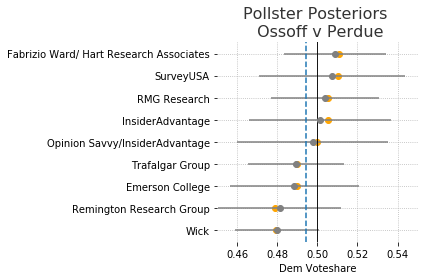

In [104]:
medians = []
errs = []
labels = []
for pollster_idx in range(ossoff_samples['thetas'].shape[1]):
    _median = np.mean(ossoff_samples['thetas'][:,pollster_idx])
    lower, _ = np.percentile(ossoff_samples['thetas'][:,pollster_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(ossoff_pollsters.index.tolist()[pollster_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

#medians, errs, labels
for idx, _median in enumerate(medians):
    plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
    
for pollster_idx, pollster in enumerate(labels):
    plt.scatter(
        x=(
            ossoff_pollsters[ossoff_pollsters.index == pollster]['num_votes'] / 
            ossoff_pollsters[ossoff_pollsters.index == pollster]['samplesize']
        ), 
        y=pollster_idx, color='orange')
plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
plt.axvline(x=map_estimate['phi'], linestyle='--', color='tab:blue')
plt.grid(linestyle=':')
plt.yticks(np.arange(len(ossoff_pollsters)), labels)
plt.xlabel('Dem Voteshare')
plt.xlim([0.45, 0.55])
plt.title('Pollster Posteriors \n Ossoff v Perdue', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/op_pollster-lean.png', dpi=300)

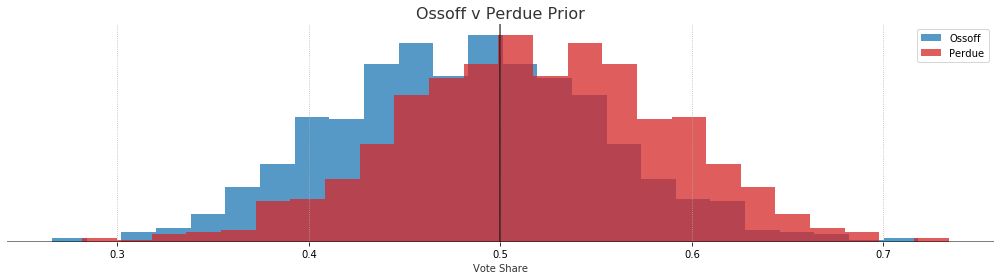

In [105]:
plt.figure(figsize=(14,4))
plt.hist(ossoff_prior['phi'], color='tab:blue', alpha=0.75, bins=25, label='Ossoff')
plt.hist(1. - ossoff_prior['phi'], color='tab:red', alpha=0.75, bins=25, label='Perdue')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Ossoff v Perdue Prior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_op_{}-priors.png'.format(PRIOR_N))

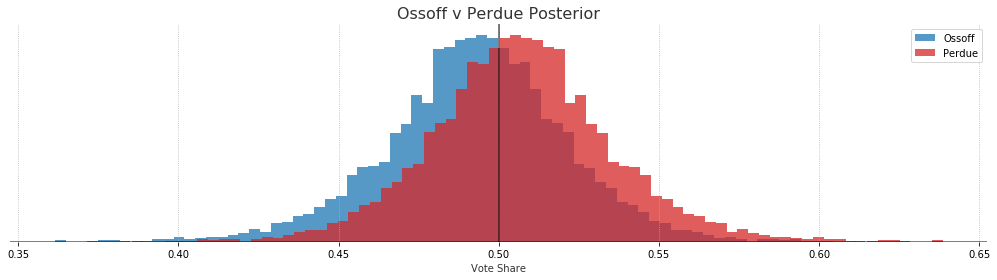

In [106]:
plt.figure(figsize=(14,4))
plt.hist(ossoff_samples['phi'], color='tab:blue', alpha=0.75, bins=75, label='Ossoff')
plt.hist(1. - ossoff_samples['phi'], color='tab:red', alpha=0.75, bins=75, label='Perdue')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Ossoff v Perdue Posterior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_op_posteriors.png')

In [107]:
np.mean(ossoff_samples['phi'] > 0.5), np.mean((1. - ossoff_samples['phi']) > 0.5) 

(0.3955, 0.6045)